# 프로젝트 - Movielens 영화 추천 실습🎞️🧠🤖

## 추천 시스템이란?
* 추천 시스템의 원리
1. 협업 필터링 : 다수의 사용자의 아이템 구매 이력 정보만으로 사용자간 유사성 및 아이템 간 유사성을 파악, 아이템과 사용자 간의 행동 또는 관계에만 주목합니다.
2. 콘텐츠 기반 필터링 : 아이템의 고유의 정보를 바탕으로 아이템 간 유사성을 파악, 아이템 자체의 속성에만 주목합니다.

다수의 사용자의 판단을 기반으로 정확한 추천을 가능하게 하는 추천시스템의 핵심 근간은 협업 필터링이지만, 협업 필터링을 바로 사용할 수 없게 만드는 세가지 제약 조건은 무엇일까요?
1. 시스템이 충분한 정보를 모으지 못한 사용자나 아이템에 대한 추론을 할 수 없는 상태인 콜드 스타트(Cold Start) 상황
2. 계산량이 너무 많아 추천의 효율이 떨어지는 상황
3. 롱테일의 꼬리 부분, 즉 사용자의 관심이 저조한 항목의 정보가 부족하여 추천에서 배제되는 상황

### Matrix Factorization(MF)모델
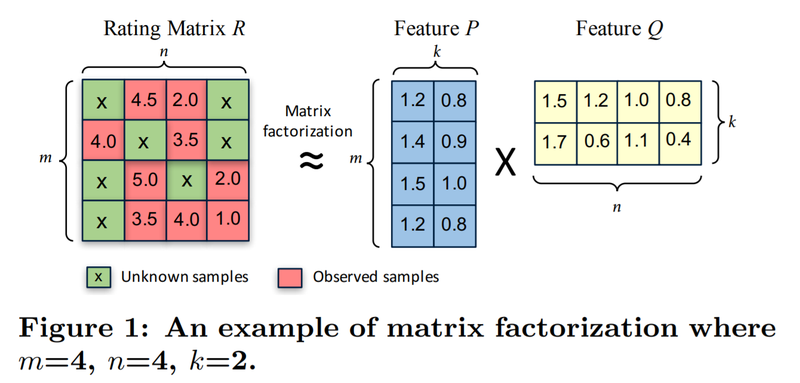
* MF 모델은 2006년 Netflix에서 백만 달러의 상금을 걸고 개최한 자사 추천 시스템의 성능을 10% 이상 향상시키는 챌린지를 계기로 알려지게 되었습니다. 기본 아이디어는 아래 그림과 같습니다. (m,n) 사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현 가능할 수 있다는 간단한 아이디어입니다. 대체로 k는 m이나 n보다 훨씬 작은 값이기 때문에 계산량 측면으로도 훨씬 유리해집니다. 하지만 아이디어의 단순함에도 불구하고 MF 모델은 성능이 준수하고 Scalability가 좋아서 많이 사용되는 모델입니다.

### CSR(Compressed Sparse Row) Matrix모델
* 거대한 행렬을 메모리에 올려놓고 작업한다는 것은 불가능하기 때문에 대안으로 CSR(Compressed Sparse Row) Matrix모델을 사용합니다. CSR Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조입니다. CSR Matrix는 data, indices, indptr 로 행렬을 압축하여 표현합니다. 

## 1) 데이터 준비와 전처리

In [1]:
import os
import pandas as pd
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']  # 임의로 지정한 컬럼명
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")  
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
ratings.tail()

,user_id,movie_id,ratings,timestamp
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


In [3]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [5]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.tail()

,movie_id,title,genre
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


In [8]:
# movie_id를 기준으로 merge 하여 새로운 데이터 프레임 생성
merge_df = pd.merge(ratings, movies, on='movie_id')
merge_df.head()

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


## 2) 분석하기

In [7]:
print("영화 개수 : ", ratings['movie_id'].nunique())
print("유저 수 : ", ratings['user_id'].nunique())

영화 개수 :  3628
유저 수 :  6039


In [9]:
# 인기 많은 영화
count_movies = merge_df.groupby('title')['user_id'].count()
count_movies = count_movies.sort_values(ascending=False)
count_movies.head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [15]:
# 사용하는 컬럼만 남겨준다
cols = ['user_id', 'title', 'counts', 'movie_id']
movie_data = merge_df[cols]
movie_data.head()

,user_id,title,counts,movie_id
0,1,One Flew Over the Cuckoo's Nest (1975),5,1193
1,2,One Flew Over the Cuckoo's Nest (1975),5,1193
2,12,One Flew Over the Cuckoo's Nest (1975),4,1193
3,15,One Flew Over the Cuckoo's Nest (1975),4,1193
4,17,One Flew Over the Cuckoo's Nest (1975),5,1193


In [36]:
movies[movies['title'].str.lower().str.contains('cube', regex=False)]

,movie_id,title,genre
2163,2232,Cube (1997),Sci-Fi|Thriller


## 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가

In [18]:
# 모델 검증을 위한 사용자 초기 정보 세팅
# 내가 선호하는 영화 5개
my_favorite_movie = [1, 2761, 2571, 648, 1246]

my_favorite_title = []
for i in my_favorite_movie:
    my_favorite_title.extend(list(movies[movies['movie_id'] == i]['title']))
    
# 유저 id, 영화 제목, 평점
my_rating = pd.DataFrame({'user_id' : ['hwan'] * 5, 'movie_id': my_favorite_movie, 'title' : my_favorite_title, 'counts' : [5] * 5})
my_rating

,user_id,movie_id,title,counts
0,hwan,1,Toy Story (1995),5
1,hwan,2761,"Iron Giant, The (1999)",5
2,hwan,2571,"Matrix, The (1999)",5
3,hwan,648,Mission: Impossible (1996),5
4,hwan,1246,Dead Poets Society (1989),5


In [19]:
# 내 점수를 뒤에 붙인다
movie_data = movie_data.append(my_rating)

In [20]:
movie_data.tail(10)

,user_id,title,counts,movie_id
836473,5851,One Little Indian (1973),5,3607
836474,5854,Slaughterhouse (1987),4,3026
836475,5854,"Promise, The (Versprechen, Das) (1994)",3,690
836476,5938,"Five Wives, Three Secretaries and Me (1998)",4,2909
836477,5948,Identification of a Woman (Identificazione di ...,5,1360
0,hwan,Toy Story (1995),5,1
1,hwan,"Iron Giant, The (1999)",5,2761
2,hwan,"Matrix, The (1999)",5,2571
3,hwan,Mission: Impossible (1996),5,648
4,hwan,Dead Poets Society (1989),5,1246


In [22]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = movie_data['user_id'].unique()
title_unique = movie_data['title'].unique()

# 유저, 영화제목 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

In [23]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['hwan'])
print(title_to_idx['Toy Story (1995)'])

6039
40


In [24]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = movie_data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(movie_data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    movie_data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# title_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = movie_data['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(movie_data):
    print('title column indexing OK!!')
    movie_data['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

movie_data

user_id column indexing OK!!
title column indexing OK!!


,user_id,title,counts,movie_id
0,0,0,5,1193
1,1,0,5,1193
2,2,0,4,1193
3,3,0,4,1193
4,4,0,5,1193
...,...,...,...,...
0,6039,40,5,1
1,6039,851,5,2761
2,6039,124,5,2571
3,6039,58,5,648


## 4) CSR matrix 만들기 

In [27]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = movie_data['user_id'].nunique()
num_movie = movie_data['title'].nunique()

csr_data = csr_matrix((movie_data['counts'], (movie_data['user_id'], movie_data['title'])), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

## 5) als_model = AlternatingLeastSquares 모델 구성, 훈련
Matrix Factorization 모델을 implicit 패키지를 사용하여 학습해 봅시다.

* implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지입니다.
* 이 패키지에 구현된 als(AlternatingLeastSquares) 모델을 사용하겠습니다. Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있습니다.

AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
3. use_gpu : GPU를 사용할 것인지
4. iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.

In [28]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [29]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [30]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [31]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

## 6) 내가 선호하는 5가지 영화와 다른 영화들의 선호도를 훈련시킨 모델로 예측

In [54]:
hwan, toy_story = user_to_idx['hwan'], title_to_idx['Toy Story (1995)']
hwan_vector, toy_story_vector = als_model.user_factors[hwan], als_model.item_factors[toy_story]
np.dot(hwan_vector, toy_story_vector)

0.52072835

In [56]:
hwan, iron_giant = user_to_idx['hwan'], title_to_idx['Iron Giant, The (1999)']
hwan_vector, iron_giant_vector = als_model.user_factors[hwan], als_model.item_factors[iron_giant]
np.dot(hwan_vector, iron_giant_vector)

0.40667418

In [55]:
hwan, matrix = user_to_idx['hwan'], title_to_idx['Matrix, The (1999)']
hwan_vector, matrix_vector = als_model.user_factors[hwan], als_model.item_factors[matrix]
np.dot(hwan_vector, matrix_vector)

0.4379458

In [57]:
hwan, mission_impossible = user_to_idx['hwan'], title_to_idx['Mission: Impossible (1996)']
hwan_vector, mission_impossible_vector = als_model.user_factors[hwan], als_model.item_factors[mission_impossible]
np.dot(hwan_vector, mission_impossible_vector)

0.42135483

In [58]:
hwan, dead_poets_society = user_to_idx['hwan'], title_to_idx['Dead Poets Society (1989)']
hwan_vector, dead_poets_society_vector = als_model.user_factors[hwan], als_model.item_factors[dead_poets_society]
np.dot(hwan_vector, dead_poets_society_vector)

0.18732436

In [59]:
hwan, cube = user_to_idx['hwan'], title_to_idx['Cube (1997)']
hwan_vector, cube_vector = als_model.user_factors[hwan], als_model.item_factors[cube]
np.dot(hwan_vector, cube_vector)

0.042980395

## 7) 내가 좋아하는 영화와 비슷한 영화를 추천받기
* AlternatingLeastSquares 클래스에 구현되어 있는 similar_items 메서드를 통하여 비슷한 영화를 찾습니다. 

In [41]:
# title_to_idx 를 뒤집어, index로부터 title 이름을 얻는 dict를 생성합니다. 
idx_to_title = {v:k for k,v in title_to_idx.items()}

In [42]:
def get_similar_title(movie_title: str):
    title_id = title_to_idx[movie_title]
    similar_movie = als_model.similar_items(title_id)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

In [44]:
get_similar_title('Matrix, The (1999)')

['Matrix, The (1999)',
 'Terminator 2: Judgment Day (1991)',
 'Total Recall (1990)',
 'Fugitive, The (1993)',
 'Terminator, The (1984)',
 'Fifth Element, The (1997)',
 'Jurassic Park (1993)',
 'Face/Off (1997)',
 'Men in Black (1997)',
 'Twelve Monkeys (1995)']

## 8) 내가 가장 좋아할 만한 영화들을 추천받기
* AlternatingLeastSquares 클래스에 구현되어 있는 recommend 메서드를 통하여 제가 좋아할 만한 영화를 추천받습니다. filter_already_liked_items 는 유저가 이미 평가한 아이템은 제외하는 Argument입니다.

In [45]:
hwan = user_to_idx['hwan']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(hwan, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(50, 0.51908153),
 (4, 0.3277024),
 (141, 0.32427475),
 (92, 0.31672218),
 (330, 0.2674663),
 (33, 0.24367195),
 (10, 0.24258521),
 (60, 0.223942),
 (372, 0.22370034),
 (67, 0.2188966),
 (38, 0.21569039),
 (474, 0.21439207),
 (322, 0.2051625),
 (1508, 0.20183726),
 (1036, 0.1910497),
 (87, 0.190554),
 (43, 0.19048655),
 (107, 0.1878975),
 (26, 0.18533085),
 (200, 0.17784981)]

In [46]:
[idx_to_title[i[0]] for i in movie_recommended]

['Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Fugitive, The (1993)',
 'Terminator 2: Judgment Day (1991)',
 'Lion King, The (1994)',
 'Aladdin (1992)',
 'Beauty and the Beast (1991)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'X-Men (2000)',
 'Gladiator (2000)',
 'Sixth Sense, The (1999)',
 'Chicken Run (2000)',
 'Babe (1995)',
 'Fantasia 2000 (1999)',
 'Princess Mononoke, The (Mononoke Hime) (1997)',
 'Braveheart (1995)',
 'Run Lola Run (Lola rennt) (1998)',
 'Jurassic Park (1993)',
 'E.T. the Extra-Terrestrial (1982)',
 'Terminator, The (1984)']

* AlternatingLeastSquares 클래스에 구현된 explain 메서드를 사용하면 제가 기록을 남긴 데이터 중 이 추천에 기여한 정도를 확인할 수 있습니다.

In [49]:
toy_story2 = title_to_idx['Toy Story 2 (1999)']
explain = als_model.explain(hwan, csr_data, itemid=toy_story2)

In [51]:
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('Toy Story (1995)', 0.40950021261481123),
 ('Iron Giant, The (1999)', 0.13219460204037647),
 ('Mission: Impossible (1996)', 0.023093348075010123),
 ('Matrix, The (1999)', -0.014245048759421628),
 ('Dead Poets Society (1989)', -0.036501309717693754)]

# 회고
* 웹이나 앱으로 정말 많이 접하고 있는 추천 시스템을 다뤄볼 수 있는 좋은 경험이 되었다. 벡터를 내적하여 선호도를 예측한다는 것이 신기했다.
* 비슷한 영화와 추천받은 영화 목록들 모두 대체로 재밌게 봤거나 흥미가 생기는 영화들이었다. 간단한 모델인데도 예상보다 정확도가 높은 것 같다
* 모델에 대한 심도있는 분석과 예측결과를 제대로 분석하려면 수학적 지식이나 알고리즘에 대해 좀 더 공부가 필요할 것 같다.